# Churn Modeling Notebook 

In [199]:
import pandas as pd 
import numpy as np 

In [200]:

df = pd.read_csv("retentiondata_case.csv")

# =========================
# 1) STANDARDIZE TEXT FIELDS
# =========================
obj_cols = df.select_dtypes(include="object").columns
for c in obj_cols:
    df[c] = df[c].astype(str).str.strip()
df.replace({"": np.nan, "None": np.nan, "nan": np.nan, "NaN": np.nan}, inplace=True)

# =========================
# 2) TARGET CLEANUP
# =========================
# Keep original left_flag for reporting if you want, but make a numeric version too
df["left_flag_num"] = df["left_flag"].map({"Yes": 1, "No": 0})

# =========================
# 3) NUMERIC TYPE FIXES
# =========================
numeric_cols = [
    "tenure_mo","age_years","monthly_fee","total_billed","avg_gb_download",
    "refunds_total","extra_data_fees_total","long_dist_fees_total","avg_long_dist_fee",
    "dependents_count","referrals_count"
]
for c in numeric_cols:
    if c in df.columns:
        df[c] = pd.to_numeric(df[c], errors="coerce")

# Basic consistency checks (clip negatives)
for c in ["monthly_fee","total_billed","refunds_total","avg_long_dist_fee","long_dist_fees_total"]:
    if c in df.columns:
        df[c] = df[c].clip(lower=0)
if "tenure_mo" in df.columns:
    df["tenure_mo"] = df["tenure_mo"].clip(lower=0)

# =========================
# 4) MISSINGNESS HANDLING
# =========================
# Keep missing as meaningful category for these
if "recent_offer" in df.columns:
    df["recent_offer"] = df["recent_offer"].fillna("Unknown")
if "internet_tech" in df.columns:
    df["internet_tech"] = df["internet_tech"].fillna("Unknown")

# total_billed: very low missingness -> median
if "total_billed" in df.columns:
    df["total_billed"] = df["total_billed"].fillna(df["total_billed"].median())

# =========================
# 5) DROP CONSTANT COLUMNS
# =========================
constant_cols = [c for c in df.columns if df[c].nunique(dropna=False) <= 1]
df = df.drop(columns=constant_cols)

# =========================
# 6) FEATURE ENGINEERING
# =========================

# Tenure group + early lifecycle flag
if "tenure_mo" in df.columns:
    bins = [0, 6, 12, 24, 36, 48, 60, 72, np.inf]
    labels = ["0–6","7–12","13–24","25–36","37–48","49–60","61–72","73+"]
    df["tenure_group"] = pd.cut(  df["tenure_mo"], bins=bins, labels=labels, include_lowest=True)
    df["early_lifecycle_flag"] = (df["tenure_mo"] <= 12).astype(int)

# Age group
if "age_years" in df.columns:
    age_bins = [0, 25, 35, 45, 55, 65, np.inf]
    age_labels = ["0–25","26–35","36–45","46–55","56–65","66+"]
    df["age_group"] = pd.cut(df["age_years"], bins=age_bins, labels=age_labels, include_lowest=True)

# Service bundle count
service_cols = [
    "add_on_security","add_on_backup","add_on_protection","tech_support_std",
    "premium_support","stream_tv","stream_movies","stream_music","unlimited_data_opt"
]
service_cols = [c for c in service_cols if c in df.columns]

def yes_no_to01(x):
    if pd.isna(x):
        return 0
    x = str(x).strip().lower()
    return 1 if x in ["yes","y","true","1"] else 0

if service_cols:
    for c in service_cols:
        df[c + "_01"] = df[c].apply(yes_no_to01)
    df["services_addon_count"] = df[[c + "_01" for c in service_cols]].sum(axis=1)

# Billing intensity
if "total_billed" in df.columns and "tenure_mo" in df.columns:
    df["avg_billed_per_month"] = df["total_billed"] / df["tenure_mo"].replace(0, 1)

# Friction flags
if "extra_data_fees_total" in df.columns:
    df["data_fee_friction_flag"] = (df["extra_data_fees_total"].fillna(0) > 0).astype(int)

if "refunds_total" in df.columns:
    df["refund_flag"] = (df["refunds_total"].fillna(0) > 0).astype(int)

# Referral flag
if "referrals_count" in df.columns:
    df["referral_flag"] = (df["referrals_count"].fillna(0) > 0).astype(int)

# Usage flag (median split)
if "avg_gb_download" in df.columns:
    cutoff = df["avg_gb_download"].median()
    df["high_usage_flag"] = (df["avg_gb_download"] > cutoff).astype(int)

# =========================
# 7) EXPORT FINAL DATASETS
# =========================
final_df = df.copy()

model_ready = df.copy()
for id_col in ["acct_ref","cust_ref"]:
    if id_col in model_ready.columns:
        model_ready = model_ready.drop(columns=[id_col])

final_df.to_csv("retention_final_dataset.csv", index=False)
model_ready.to_csv("retention_model_ready.csv", index=False)

print("Saved: retention_final_dataset.csv and retention_model_ready.csv")
print("Final shape:", final_df.shape)


Saved: retention_final_dataset.csv and retention_model_ready.csv
Final shape: (5636, 54)


In [201]:
len(feature_names)


99

C:\Users\omogun01\AppData\Local\Temp\ipykernel_42280\3204084510.py:11: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  df_plot.groupby(["age_group", "has_dependents"])["left_flag"]


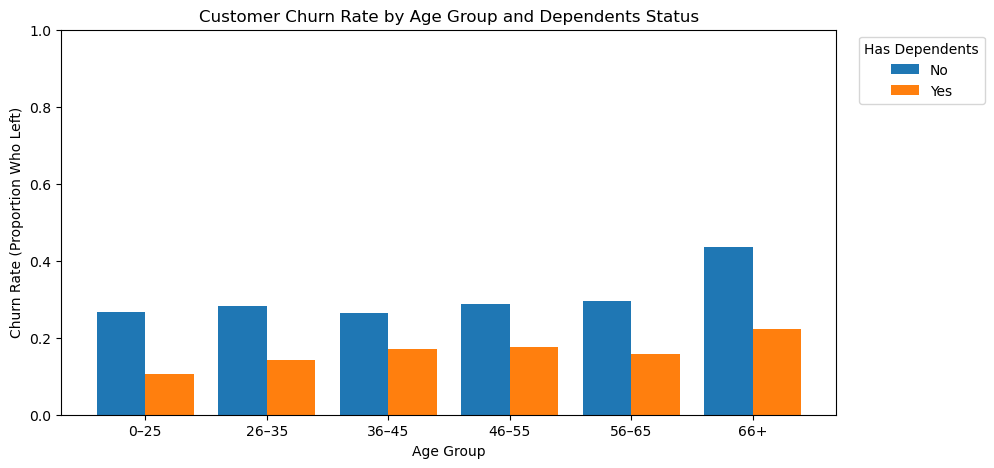

has_dependents,No,Yes
age_group,,
0–25,0.267368,0.104839
26–35,0.281437,0.142405
36–45,0.263785,0.171053
46–55,0.288600,0.176292
56–65,0.295559,0.157576
66+,0.436637,0.223684


In [202]:
import matplotlib.pyplot as plt

df_plot = df.copy()
df_plot["has_dependents"] = df_plot["has_dependents"].fillna("Unknown")

bins = [0, 25, 35, 45, 55, 65, 120]
labels = ["0–25", "26–35", "36–45", "46–55", "56–65", "66+"]
df_plot["age_group"] = pd.cut(df_plot["age_years"], bins=bins, labels=labels, include_lowest=True)

rates = (
    df_plot.groupby(["age_group", "has_dependents"])["left_flag"]
    .apply(lambda s: (s == "Yes").mean())
    .reset_index(name="churn_rate")
)

wide = rates.pivot(index="age_group", columns="has_dependents", values="churn_rate").fillna(0)

x = np.arange(len(wide.index))
bar_width = 0.8 / len(wide.columns)

plt.figure(figsize=(10,5))
for i, col in enumerate(wide.columns):
    plt.bar(x + i*bar_width, wide[col].values, width=bar_width, label=str(col))

plt.xticks(x + bar_width*(len(wide.columns)-1)/2, wide.index.astype(str), rotation=0)
plt.ylim(0, 1)
plt.xlabel("Age Group")
plt.ylabel("Churn Rate (Proportion Who Left)")
plt.title("Customer Churn Rate by Age Group and Dependents Status")
plt.legend(title="Has Dependents", bbox_to_anchor=(1.02, 1), loc="upper left")

plt.savefig("fig_churn_age_dependents.jpg", dpi=300, bbox_inches="tight")
plt.show()

wide


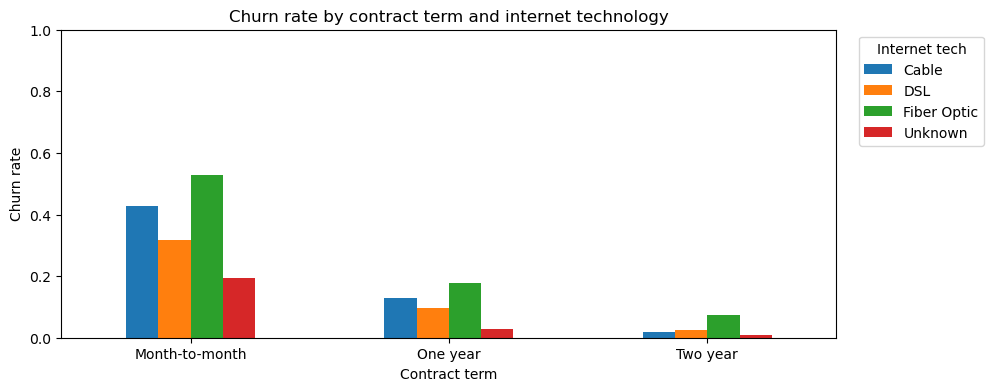

Churn rate summary (proportions):
internet_tech   Cable    DSL  Fiber Optic  Unknown
contract_term                                     
Month-to-month  0.427  0.319        0.529    0.193
One year        0.130  0.095        0.178    0.027
Two year        0.019  0.024        0.075    0.008

Churn rate summary (percentages):
internet_tech   Cable   DSL  Fiber Optic  Unknown
contract_term                                    
Month-to-month   42.7  31.9         52.9     19.3
One year         13.0   9.5         17.8      2.7
Two year          1.9   2.4          7.5      0.8


In [46]:



pivot = df.pivot_table(
    index="contract_term",
    columns="internet_tech",
    values="left_flag_num",
    aggfunc="mean"
)

pivot = pivot.sort_index()

pivot.plot(kind="bar", figsize=(10,4))
plt.title("Churn rate by contract term and internet technology")
plt.ylabel("Churn rate")
plt.xlabel("Contract term")
plt.xticks(rotation=0)
plt.ylim(0, 1)
plt.legend(title="Internet tech", bbox_to_anchor=(1.02, 1), loc="upper left")
plt.show()
# Summary table (churn rates)
print("Churn rate summary (proportions):")
print(pivot.round(3))

print("\nChurn rate summary (percentages):")
print((pivot * 100).round(1))



Churn rate summary (proportions):
internet_tech   Cable    DSL  Fiber Optic  Unknown
contract_term                                     
Month-to-month  0.427  0.319        0.529    0.193
One year        0.130  0.095        0.178    0.027
Two year        0.019  0.024        0.075    0.008

Churn rate summary (percentages):
internet_tech   Cable   DSL  Fiber Optic  Unknown
contract_term                                    
Month-to-month   42.7  31.9         52.9     19.3
One year         13.0   9.5         17.8      2.7
Two year          1.9   2.4          7.5      0.8


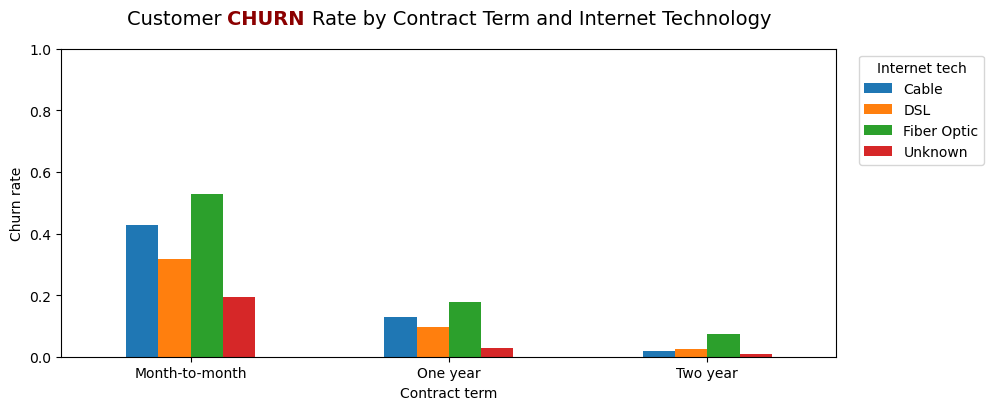

In [203]:


pivot = df.pivot_table(
    index="contract_term",
    columns="internet_tech",
    values="left_flag_num",
    aggfunc="mean"
)

pivot = pivot.sort_index()

fig, ax = plt.subplots(figsize=(10,4))
pivot.plot(kind="bar", ax=ax)

# --------------------------------
# TRUE centered title with CHURN in red
# --------------------------------
y = 1.08
fontsize = 14

# Create text objects (initially invisible)
t1 = ax.text(0, y, "Customer ", fontsize=fontsize, transform=ax.transAxes)
t2 = ax.text(0, y, "CHURN ", fontsize=fontsize, color="darkred",
             fontweight="bold", transform=ax.transAxes)
t3 = ax.text(0, y, "Rate by Contract Term and Internet Technology",
             fontsize=fontsize, transform=ax.transAxes)

# Draw once to get renderer
fig.canvas.draw()
renderer = fig.canvas.get_renderer()

# Measure widths (in pixels)
w1 = t1.get_window_extent(renderer).width
w2 = t2.get_window_extent(renderer).width
w3 = t3.get_window_extent(renderer).width
total_width = w1 + w2 + w3

# Convert center position from axes → pixels
center_x = ax.transAxes.transform((0.5, 0))[0]
start_x = center_x - total_width / 2

# Convert pixel positions back to axes coords
inv = ax.transAxes.inverted()
x1 = inv.transform((start_x, 0))[0]
x2 = inv.transform((start_x + w1, 0))[0]
x3 = inv.transform((start_x + w1 + w2, 0))[0]

# Re-position text exactly
t1.set_position((x1, y))
t2.set_position((x2, y))
t3.set_position((x3, y))

# --------------------------------
# Axis & legend formatting
# --------------------------------
ax.set_ylabel("Churn rate")
ax.set_xlabel("Contract term")
ax.set_ylim(0, 1)
ax.set_xticklabels(ax.get_xticklabels(), rotation=0)
ax.legend(title="Internet tech", bbox_to_anchor=(1.02, 1), loc="upper left")



# --------------------------------
# Summary tables
# --------------------------------
print("Churn rate summary (proportions):")
print(pivot.round(3))

print("\nChurn rate summary (percentages):")
print((pivot * 100).round(1))

# SAVE FIGURE AS JPG (do this BEFORE plt.show())
plt.savefig(
    "churn_rate_by_contract_and_internet_technew.jpg",
    dpi=300,
    bbox_inches="tight"
)

plt.show()



In [17]:
import os
print(os.getcwd())


C:\Users\omogun01\Predictive Analysis


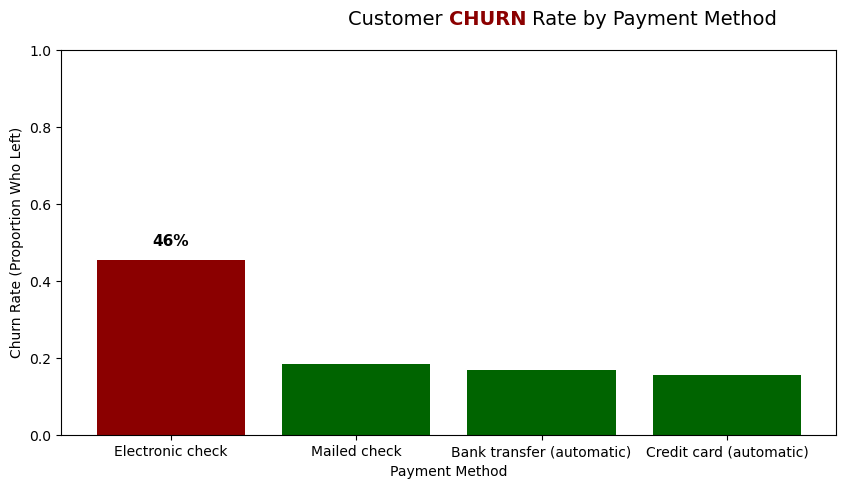

pay_method
Electronic check             0.455121
Mailed check                 0.184783
Bank transfer (automatic)    0.168006
Credit card (automatic)      0.154545
Name: left_flag, dtype: float64

In [204]:
# -------------------------------------------------
# ENSURE WE ARE USING THE CLEANED / ENGINEERED DATA
# -------------------------------------------------
df = pd.read_csv("retention_final_dataset.csv")

pay_col = "pay_method"

df_plot = df.copy()
df_plot[pay_col] = df_plot[pay_col].fillna("Unknown")

# --------------------------------
# Compute churn rate
# --------------------------------
summary = (
    df_plot.groupby(pay_col)["left_flag"]
    .apply(lambda s: (s == "Yes").mean())
    .sort_values(ascending=False)
)

# --------------------------------
# Color by churn severity
# --------------------------------
colors = []
for rate in summary.values:
    if rate >= 0.40:
        colors.append("darkred")
    elif rate >= 0.25:
        colors.append("orange")
    else:
        colors.append("darkgreen")

# --------------------------------
# Plot
# --------------------------------
plt.figure(figsize=(10, 5))
bars = plt.bar(summary.index.astype(str), summary.values, color=colors)
plt.ylim(0, 1)
plt.xlabel("Payment Method")
plt.ylabel("Churn Rate (Proportion Who Left)")
plt.xticks(rotation=0)

# --------------------------------
# Title with ONLY 'CHURN' in red
# --------------------------------
ax = plt.gca()
ax.text(0.5, 1.08, "Customer ", transform=ax.transAxes,
        ha="right", va="center", fontsize=14)
ax.text(0.5, 1.08, "CHURN", transform=ax.transAxes,
        ha="left", va="center", fontsize=14, color="darkred", fontweight="bold")
ax.text(0.60, 1.08, " Rate by Payment Method", transform=ax.transAxes,
        ha="left", va="center", fontsize=14)

# --------------------------------
# Add percentage label to highest bar only
# --------------------------------
max_idx = summary.values.argmax()
max_bar = bars[max_idx]
max_value = summary.values[max_idx]

plt.text(
    max_bar.get_x() + max_bar.get_width() / 2,
    max_value + 0.03,
    f"{max_value:.0%}",
    ha="center",
    va="bottom",
    fontsize=11,
    fontweight="bold",
    color="black"
)

# --------------------------------
# Save for Word
# --------------------------------
plt.savefig("fig_churn_by_payment_method_color.jpg", dpi=300, bbox_inches="tight")
plt.show()

summary


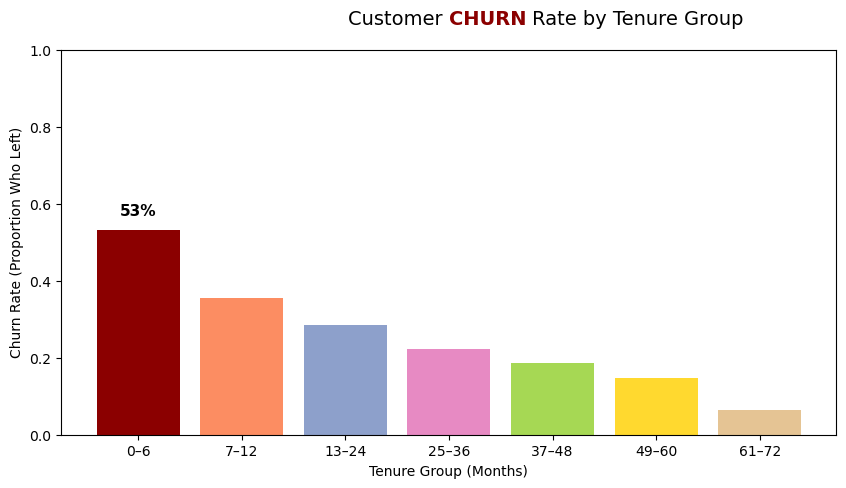

tenure_group
0–6      0.532995
7–12     0.355476
13–24    0.285012
25–36    0.222883
37–48    0.186992
49–60    0.146884
61–72    0.064228
Name: left_flag, dtype: float64

In [205]:
df = pd.read_csv("retention_final_dataset.csv")

tenure_col = "tenure_group"

summary = (
    df.groupby(tenure_col)["left_flag"]
    .apply(lambda s: (s == "Yes").mean())
)

#tenure order
tenure_order = ["0–6","7–12","13–24","25–36","37–48","49–60","61–72","73+"]
summary = summary.reindex([g for g in tenure_order if g in summary.index])

# ---------------------------------------------
# categorical colors
# ---------------------------------------------
base_colors = list(plt.cm.Set2.colors[:len(summary)])

# Force highest churn group to red
max_idx = summary.values.argmax()
base_colors[max_idx] = "darkred"


# ---------------------------------------------
plt.figure(figsize=(10,5))
bars = plt.bar(summary.index.astype(str), summary.values, color=base_colors)
plt.ylim(0, 1)
plt.xlabel("Tenure Group (Months)")
plt.ylabel("Churn Rate (Proportion Who Left)")
plt.xticks(rotation=0)

# ---------------------------------------------
# Title with ONLY 'CHURN' in red
# ---------------------------------------------
ax = plt.gca()
ax.text(0.5, 1.08, "Customer ", transform=ax.transAxes,
        ha="right", va="center", fontsize=14)
ax.text(0.5, 1.08, "CHURN", transform=ax.transAxes,
        ha="left", va="center", fontsize=14, color="darkred", fontweight="bold")
ax.text(0.60, 1.08, " Rate by Tenure Group", transform=ax.transAxes,
        ha="left", va="center", fontsize=14)


max_bar = bars[max_idx]
max_value = summary.values[max_idx]

plt.text(
    max_bar.get_x() + max_bar.get_width() / 2,
    max_value + 0.03,
    f"{max_value:.0%}",
    ha="center",
    va="bottom",
    fontsize=11,
    fontweight="bold",
    color="black"
)


plt.savefig("fig_churn_by_tenure_group_highlight.jpg", dpi=300, bbox_inches="tight")
plt.show()

summary


In [206]:
# =========================
# 0) Imports & Settings
# =========================

from sklearn.model_selection import train_test_split, StratifiedKFold, GridSearchCV
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import OneHotEncoder

from sklearn.metrics import roc_auc_score, average_precision_score, confusion_matrix, classification_report

from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from xgboost import XGBClassifier

RANDOM_STATE = 99


In [207]:
# =========================
# 1) Load Data
# =========================
# Choose the most 'model-ready' file you created in your workflow.
DATA_PATH = "retention_model_ready.csv"  # change if needed

df = pd.read_csv(DATA_PATH)
df.head()


,has_dependents,tenure_mo,home_phone,multi_line,internet_plan,add_on_security,add_on_backup,add_on_protection,tech_support_std,stream_tv,...,stream_tv_01,stream_movies_01,stream_music_01,unlimited_data_opt_01,services_addon_count,avg_billed_per_month,data_fee_friction_flag,refund_flag,referral_flag,high_usage_flag
0,No,1,No,No phone service,DSL,No,Yes,No,No,No,...,0,0,0,1,2,29.850000,0,0,0,0
1,No,34,Yes,No,DSL,Yes,No,Yes,No,No,...,0,0,0,1,3,55.573529,0,0,0,0
2,No,2,Yes,No,DSL,Yes,Yes,No,No,No,...,0,0,0,1,3,54.075000,0,0,0,1
3,No,45,No,No phone service,DSL,Yes,No,Yes,Yes,No,...,0,0,0,1,5,40.905556,0,0,0,0
4,No,2,Yes,No,Fiber optic,No,No,No,No,No,...,0,0,0,1,1,75.825000,0,0,0,1


In [208]:
# =========================
# 2) Define Target (y) and Features (X)
# =========================
# Preferred target column:
# - left_flag_num (already numeric)
# Fallback:
# - left_flag (Yes/No)

if "left_flag_num" in df.columns:
    TARGET_COL = "left_flag_num"
    y = df[TARGET_COL].astype(int)
else:
    TARGET_COL = "left_flag"
    # Map Yes/No to 1/0 safely
    y = (df[TARGET_COL].astype(str).str.strip().str.lower()
         .map({"yes": 1, "no": 0}))
    if y.isna().any():
        raise ValueError("Target contains values other than Yes/No. Check left_flag values.")

# Build X and remove target + any duplicate label columns
X = df.drop(columns=[TARGET_COL], errors="ignore")
X = X.drop(columns=["left_flag"], errors="ignore")  # drop string label if present


In [209]:
# =========================
# 3) Quick Leakage / ID Checks (Recommended)
# =========================
# 1) Ensure target is not in X
print("Is TARGET in X?", TARGET_COL in X.columns)

# 2) Flag suspicious columns (keywords)
leak_words = ["left", "churn", "cancel", "terminate", "refund", "flag", "drop"]
suspect_cols = [c for c in X.columns if any(w in c.lower() for w in leak_words)]
print("Potential leakage columns (review):", suspect_cols)

# 3) Identify ID-like columns by name
id_like = [c for c in X.columns if "id" in c.lower() or "phone" in c.lower()]
print("ID-like columns (review):", id_like)

# OPTIONAL: drop ID-like columns if they exist
# X = X.drop(columns=id_like, errors="ignore")


Is TARGET in X? False
Potential leakage columns (review): ['refunds_total', 'early_lifecycle_flag', 'data_fee_friction_flag', 'refund_flag', 'referral_flag', 'high_usage_flag']
ID-like columns (review): ['home_phone']


In [210]:
# =========================
# 4) Train/Test Split (Holdout Test Set)
# =========================
X_train, X_test, y_train, y_test = train_test_split(
    X, y,
    test_size=0.2,
    stratify=y,
    random_state=RANDOM_STATE
)

print("Train size:", X_train.shape, "| Test size:", X_test.shape)
print("Churn rate (train):", y_train.mean(), "| Churn rate (test):", y_test.mean())


Train size: (4508, 50) | Test size: (1128, 50)
Churn rate (train): 0.265527950310559 | Churn rate (test): 0.2650709219858156


In [211]:
# =========================
# 5) Preprocessing (Numeric + Categorical)
# =========================
num_cols = X_train.select_dtypes(include=[np.number, "bool"]).columns.tolist()
cat_cols = [c for c in X_train.columns if c not in num_cols]

numeric_pipe = Pipeline([
    ("imputer", SimpleImputer(strategy="median"))
])

categorical_pipe = Pipeline([
    ("imputer", SimpleImputer(strategy="most_frequent")),
    ("onehot", OneHotEncoder(handle_unknown="ignore"))
])

preprocess = ColumnTransformer([
    ("num", numeric_pipe, num_cols),
    ("cat", categorical_pipe, cat_cols)
])


In [ ]:
# =========================
# 6.) Model Pipelines + Hyperparameter Search (CV)
# =========================
cv = StratifiedKFold(n_splits=6, shuffle=True, random_state=RANDOM_STATE)
scoring = "roc_auc"

pipelines = {
    "Logistic Regression": Pipeline([
        ("prep", preprocess),
        ("model", LogisticRegression(max_iter=5000, solver="liblinear", class_weight="balanced"))
    ]),
    "Random Forest": Pipeline([
        ("prep", preprocess),
        ("model", RandomForestClassifier(random_state=RANDOM_STATE, class_weight="balanced_subsample", n_jobs=-1))
    ]),
    "Gradient Boosting": Pipeline([
        ("prep", preprocess),
        ("model", GradientBoostingClassifier(random_state=RANDOM_STATE))
    ]),
    "XGBoost": Pipeline([
        ("prep", preprocess),
        ("model", XGBClassifier( random_state=RANDOM_STATE, n_jobs=-1, objective="binary:logistic", eval_metric="auc", use_label_encoder=False ))
    ])
}

param_grids = {
    "Logistic Regression": {"model__C": [0.1, 1, 10]},
    "Random Forest": {
        "model__n_estimators": [200, 400],
        "model__max_depth": [None, 8, 12],
        "model__min_samples_split": [2, 10]
    },
    "Gradient Boosting": {
        "model__n_estimators": [100, 200, 400],
        "model__learning_rate": [0.01, 0.05, 0.1],
        "model__max_depth": [2, 3]
    },
    "XGBoost": {
        "model__n_estimators": [200, 400,600],
        "model__max_depth": [3, 5],
        "model__learning_rate": [0.03, 0.05, 0.1],
        "model__subsample": [0.8, 0.9, 1.0],
        "model__colsample_bytree": [0.8, 0.9, 1.0]
    }
}

best_estimators = {}
rows = []

for name, pipe in pipelines.items():
    print(f"Running {name}...")
    search = GridSearchCV(
        estimator=pipe,
        param_grid=param_grids[name],
        cv=cv,
        scoring=scoring,
        n_jobs=-1
    )
    search.fit(X_train, y_train)

    best_estimators[name] = search.best_estimator_
    rows.append({"Model": name, "best_cv_auc": search.best_score_})

model_results = pd.DataFrame(rows).sort_values("best_cv_auc", ascending=False)
model_results


Running Logistic Regression...
Running Random Forest...
Running Gradient Boosting...
Running XGBoost...


,Model,best_cv_auc
3,XGBoost,0.900209
2,Gradient Boosting,0.897628
0,Logistic Regression,0.887454
1,Random Forest,0.874834


In [33]:
# =========================
# 7) Winner + Final Test Set Evaluation (Winner Only)
# =========================
winner = model_results.iloc[0]["Model"]
best_model = best_estimators[winner]

# Refit on full training set (best practice)
best_model.fit(X_train, y_train)

y_proba = best_model.predict_proba(X_test)[:, 1]

test_roc_auc = roc_auc_score(y_test, y_proba)
test_pr_auc  = average_precision_score(y_test, y_proba)

print("Winning model:", winner)
print("Final Test ROC-AUC:", round(test_roc_auc, 4))
print("Final Test PR-AUC: ", round(test_pr_auc, 4))

y_pred = (y_proba >= 0.5).astype(int)

print("\nConfusion Matrix:")
print(confusion_matrix(y_test, y_pred))

print("\nClassification Report (threshold=0.50):")
print(classification_report(y_test, y_pred, digits=3))


Winning model: XGBoost
Final Test ROC-AUC: 0.9086
Final Test PR-AUC:  0.7828

Confusion Matrix:
[[769  60]
 [ 98 201]]

Classification Report (threshold=0.50):
              precision    recall  f1-score   support

           0      0.887     0.928     0.907       829
           1      0.770     0.672     0.718       299

    accuracy                          0.860      1128
   macro avg      0.829     0.800     0.812      1128
weighted avg      0.856     0.860     0.857      1128



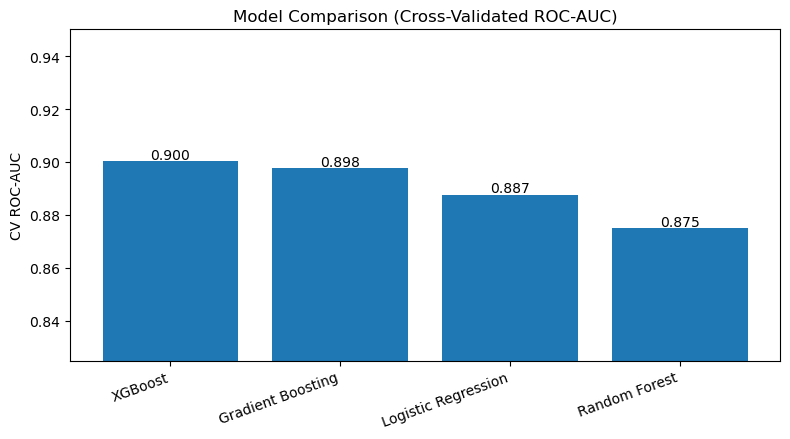

In [214]:
# =========================
# 8) Model Comparison Chart (CV ROC-AUC)
# =========================
plot_df = model_results.copy()
plt.figure(figsize=(8, 4.5))
plt.bar(plot_df["Model"], plot_df["best_cv_auc"])
plt.ylabel("CV ROC-AUC")
plt.title("Model Comparison (Cross-Validated ROC-AUC)")
plt.xticks(rotation=20, ha="right")

for i, v in enumerate(plot_df["best_cv_auc"]):
    plt.text(i, v + 0.001, f"{v:.3f}", ha="center", fontsize=10)

plt.ylim(max(0.5, plot_df["best_cv_auc"].min() - 0.05), min(1.0, plot_df["best_cv_auc"].max() + 0.05))
plt.tight_layout()
# SAVE FIGURE AS JPG (do this BEFORE plt.show())
plt.savefig(
    "Model_comparison.jpg",
    dpi=300,
    bbox_inches="tight"
)

plt.show()



In [40]:

from sklearn.metrics import roc_auc_score, average_precision_score

def bootstrap_ci_auc(y_true, y_proba, metric_fn, n_boot=2000, seed=42, ci=0.95):
    """
    Bootstrap confidence interval for a metric computed from y_true and y_proba.
    metric_fn should accept (y_true, y_proba) and return a float (e.g., roc_auc_score).
    """
    rng = np.random.default_rng(seed)
    y_true = np.asarray(y_true)
    y_proba = np.asarray(y_proba)

    n = len(y_true)
    stats = []

    for _ in range(n_boot):
        idx = rng.integers(0, n, n)  # sample with replacement
        yt = y_true[idx]
        yp = y_proba[idx]

        # Skip samples that contain only one class (AUC undefined)
        if len(np.unique(yt)) < 2:
            continue

        stats.append(metric_fn(yt, yp))

    stats = np.array(stats)
    alpha = (1 - ci) / 2
    lower = np.quantile(stats, alpha)
    upper = np.quantile(stats, 1 - alpha)

    return stats.mean(), lower, upper


# ---------------------------------------------------
# After you already computed y_proba on the TEST set:
# y_proba = best_model.predict_proba(X_test)[:, 1]
# ---------------------------------------------------

roc_mean, roc_lo, roc_hi = bootstrap_ci_auc(y_test, y_proba, roc_auc_score, n_boot=2000, seed=42, ci=0.95)
pr_mean, pr_lo, pr_hi   = bootstrap_ci_auc(y_test, y_proba, average_precision_score, n_boot=2000, seed=42, ci=0.95)

print(f"Bootstrapped Test ROC-AUC: {roc_mean:.4f}  (95% CI: {roc_lo:.4f} – {roc_hi:.4f})")
print(f"Bootstrapped Test PR-AUC:  {pr_mean:.4f}  (95% CI: {pr_lo:.4f} – {pr_hi:.4f})")


Bootstrapped Test ROC-AUC: 0.9086  (95% CI: 0.8905 – 0.9257)
Bootstrapped Test PR-AUC:  0.7828  (95% CI: 0.7359 – 0.8255)


In [227]:
from sklearn.metrics import confusion_matrix, precision_score, recall_score, f1_score, accuracy_score

def threshold_sweep(y_true, y_proba, thresholds):
    rows = []
    y_true = np.asarray(y_true)

    for t in thresholds:
        y_pred = (y_proba >= t).astype(int)

        tn, fp, fn, tp = confusion_matrix(y_true, y_pred).ravel()

        precision = precision_score(y_true, y_pred)
        recall    = recall_score(y_true, y_pred)
        f1        = f1_score(y_true, y_pred)
        accuracy  = accuracy_score(y_true, y_pred)
        specificity = tn / (tn + fp)

        rows.append({
            "threshold": t,
            "precision": precision,
            "recall": recall,
            "f1": f1,
            "accuracy": accuracy,
            "specificity": specificity,
            "tp": tp, "fp": fp, "tn": tn, "fn": fn
        })

        # Optional: keep your original print style
        print(
            f"t={t:.2f} | "
            f"precision={precision:.3f} "
            f"recall={recall:.3f} "
            f"f1={f1:.3f} | "
            f"cm={[[tn, fp], [fn, tp]]}"
        )

    return pd.DataFrame(rows)


In [229]:
print("X_train:", X_train.shape)
print("X_test:", X_test.shape)
print("y_train:", y_train.shape)
print("y_test:", y_test.shape)

print("Prediction shape:", y_pred.shape)


X_train: (4508, 50)
X_test: (1128, 50)
y_train: (4508,)
y_test: (1128,)
Prediction shape: (1407,)


In [234]:
# Predict probabilities
y_prob = best_model.predict_proba(X_test)[:, 1]

# Choose threshold (if you already defined one, use it)
threshold = 0.40

# Convert to class predictions
y_pred = (y_prob >= threshold).astype(int)

# Evaluate
from sklearn.metrics import confusion_matrix, roc_auc_score, classification_report

print("ROC-AUC:", roc_auc_score(y_test, y_prob))
print("Confusion Matrix:")
print(confusion_matrix(y_test, y_pred))
print("\nClassification Report:")
print(classification_report(y_test, y_pred))


ROC-AUC: 0.9086036688438743
Confusion Matrix:
[[720 109]
 [ 67 232]]

Classification Report:
              precision    recall  f1-score   support

           0       0.91      0.87      0.89       829
           1       0.68      0.78      0.72       299

    accuracy                           0.84      1128
   macro avg       0.80      0.82      0.81      1128
weighted avg       0.85      0.84      0.85      1128



In [247]:
import pandas as pd
from sklearn.metrics import precision_score, recall_score, f1_score, accuracy_score, confusion_matrix

thresholds = [0.25, 0.30, 0.35, 0.40, 0.50]

rows = []

for t in thresholds:
    y_pred = (y_proba >= t).astype(int)
    
    tn, fp, fn, tp = confusion_matrix(y_test, y_pred).ravel()
    
    rows.append({
        "threshold": t,
        "precision": precision_score(y_test, y_pred),
        "recall": recall_score(y_test, y_pred),
        "f1": f1_score(y_test, y_pred),
        "accuracy": accuracy_score(y_test, y_pred),
        "specificity": tn / (tn + fp),
        "tp": tp,
        "fp": fp,
        "tn": tn,
        "fn": fn
    })

sweep_df = pd.DataFrame(rows)

# Round for clean display
sweep_df = sweep_df.round(6)

display(sweep_df)


,threshold,precision,recall,f1,accuracy,specificity,tp,fp,tn,fn
0,0.25,0.556034,0.862876,0.676278,0.781028,0.751508,258,206,623,41
1,0.30,0.591449,0.832776,0.691667,0.803191,0.792521,249,172,657,50
2,0.35,0.621762,0.802676,0.700730,0.818262,0.823884,240,146,683,59
3,0.40,0.680352,0.775920,0.725000,0.843972,0.868516,232,109,720,67
4,0.50,0.770115,0.672241,0.717857,0.859929,0.927624,201,60,769,98


In [248]:
# Get fitted preprocessing step
preprocessor = best_model.named_steps["prep"]

# Get feature names AFTER one-hot encoding
feature_names = preprocessor.get_feature_names_out()


In [249]:
# Get the trained XGBoost model
xgb_model = best_model.named_steps["model"]

# XGBoost feature importances (gain-based by default)
importances = xgb_model.feature_importances_

# Build a DataFrame
importance_df = (
    pd.DataFrame({
        "feature": feature_names,
        "importance": importances
    })
    .sort_values("importance", ascending=False)
)

# View top 15
top15 = importance_df.head(15)
display(top15)


,feature,importance
55,cat__contract_term_Month-to-month,0.183632
46,cat__tech_support_std_No,0.114924
37,cat__add_on_security_No,0.082252
35,cat__internet_plan_Fiber optic,0.077108
62,cat__pay_method_Electronic check,0.042729
5,num__referrals_count,0.036778
27,cat__has_dependents_No,0.033052
57,cat__contract_term_Two year,0.031049
4,num__dependents_count,0.027343
0,num__tenure_mo,0.022874


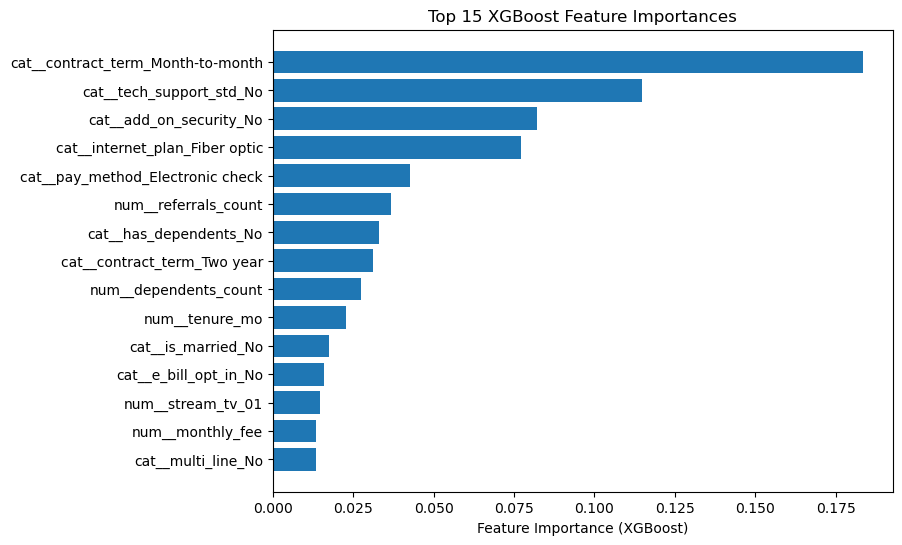

In [223]:


# Use the top 15 features you already computed
top15 = importance_df.head(15)

plt.figure(figsize=(8, 6))

plt.barh(
    top15["feature"][::-1],        # reverse so most important is on top
    top15["importance"][::-1]
)

plt.xlabel("Feature Importance (XGBoost)")
plt.title("Top 15 XGBoost Feature Importances")

# SAVE AS JPEG
plt.savefig(
    "xgboost_top15_feature_importance.jpg",
    dpi=300,
    bbox_inches="tight"
)

plt.show()


In [250]:
import shap

In [251]:
# Get preprocessing step and trained XGBoost model
preprocessor = best_model.named_steps["prep"]
xgb_model = best_model.named_steps["model"]

# Transform the test set
X_test_transformed = preprocessor.transform(X_test)

# Get feature names after one-hot encoding
feature_names = preprocessor.get_feature_names_out()


In [69]:
explainer = shap.TreeExplainer(xgb_model)
shap_values = explainer.shap_values(X_test_transformed)


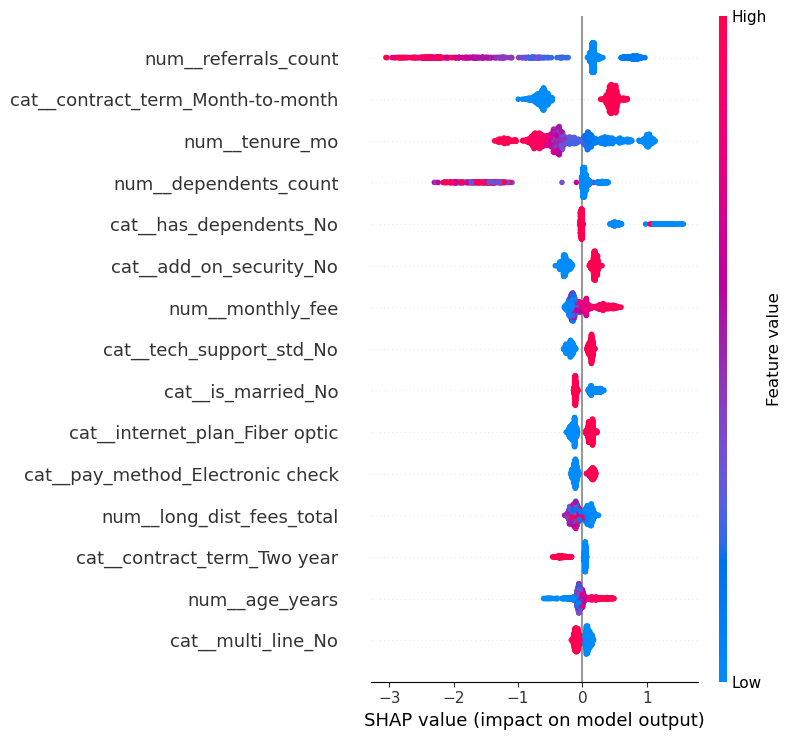

<Figure size 640x480 with 0 Axes>

In [252]:
shap.summary_plot(
    shap_values,
    X_test_transformed,
    feature_names=feature_names,
    max_display=15
)
plt.savefig(
    "shap_plot.jpg",
    dpi=300,
    bbox_inches="tight"
)

plt.show()



In [253]:
print(type(best_model))
print(type(shap_values))
print(X_test_transformed.shape)


<class 'sklearn.pipeline.Pipeline'>
<class 'numpy.ndarray'>
(1128, 99)


Pipeline(steps=[('prep',
                 ColumnTransformer(transformers=[('num',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer(strategy='median'))]),
                                                  ['tenure_mo', 'monthly_fee',
                                                   'total_billed', 'age_years',
                                                   'dependents_count',
                                                   'referrals_count',
                                                   'avg_long_dist_fee',
                                                   'avg_gb_download',
                                                   'refunds_total',
                                                   'extra_data_fees_total',
                                                   'long_dist_fees_total',
                                                   'early_lifecycle_flag',


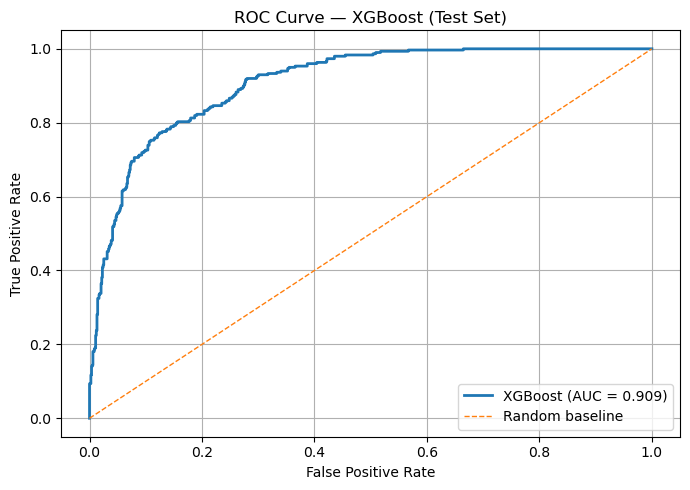

In [254]:

from sklearn.metrics import roc_curve, roc_auc_score

# Predict probabilities on test set
y_proba = best_model.predict_proba(X_test)[:, 1]

# ROC curve
fpr, tpr, thresholds = roc_curve(y_test, y_proba)
roc_auc = roc_auc_score(y_test, y_proba)
plt.figure(figsize=(7, 5))

plt.plot(fpr, tpr, linewidth=2, label=f"XGBoost (AUC = {roc_auc:.3f})")
plt.plot([0, 1], [0, 1], linestyle="--", linewidth=1, label="Random baseline")

plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve — XGBoost (Test Set)")
plt.legend(loc="lower right")
plt.grid(True)

plt.tight_layout()

print(best_model)
plt.savefig(
    "ROC_Curve.jpg",
    dpi=300,
    bbox_inches="tight"
)

plt.show()

In [255]:
features = [
    "tenure_mo",
    "monthly_fee",
    "avg_billed_per_month",
    "extra_data_fees_total",
    "refunds_total",
    "services_addon_count",
    "referrals_count"
]

# Percentiles you’ll typically use for rules
percentiles = [0.1, 0.25, 0.5, 0.75, 0.9]

df[features].quantile(percentiles)


,tenure_mo,monthly_fee,avg_billed_per_month,extra_data_fees_total,refunds_total,services_addon_count,referrals_count
0.10,2.0,20.075,20.200000,0.0,0.0,0.0,0.0
0.25,9.0,35.750,36.946523,0.0,0.0,1.0,0.0
0.50,29.0,70.300,70.489593,0.0,0.0,3.0,0.0
0.75,55.0,89.900,90.321628,0.0,0.0,5.0,3.0
0.90,69.0,103.025,103.126976,10.0,0.0,7.0,7.0


In [256]:
df.groupby("left_flag_num")[features].quantile([0.25, 0.5, 0.75])


tenure_mo  monthly_fee  avg_billed_per_month  \
left_flag_num                                                      
0             0.25      15.00      25.1500             25.556522   
              0.50      38.00      64.5250             64.395657   
              0.75      61.00      88.6125             88.020199   
1             0.25       2.00      55.6875             56.628365   
              0.50      10.00      79.5000             79.159659   
              0.75      29.25      94.1000             93.789732   

                    extra_data_fees_total  refunds_total  \
left_flag_num                                              
0             0.25                    0.0            0.0   
              0.50                    0.0            0.0   
              0.75                    0.0            0.0   
1             0.25                    0.0            0.0   
              0.50                    0.0            0.0   
              0.75                    0.0            0.0   

                    services_addon_count  referrals_count  
left_flag_num                                              
0             0.25                   0.0              0.0  
              0.50                   3.0              1.0  
              0.75                   6.0              5.0  
1             0.25                   1.0              0.0  
              0.50                   3.0              0.0  
              0.75                   5.0              1.0

In [257]:
bill_shock_cutoff = df["extra_data_fees_total"].quantile(0.75)
high_value_cutoff = df["services_addon_count"].quantile(0.75)

df["segment"] = "Stable Core"

df.loc[df["extra_data_fees_total"] > bill_shock_cutoff, "segment"] = "Bill-Shock Risk"
df.loc[
    (df["extra_data_fees_total"] <= bill_shock_cutoff) &
    (df["tenure_mo"] <= 12) &
    (df["services_addon_count"] <= 1),
    "segment"
] = "New & Under-Adopted"


In [258]:
features = [
    "tenure_mo",
    "monthly_fee",
    "avg_billed_per_month",
    "extra_data_fees_total",
    "refunds_total",
    "services_addon_count",
    "referrals_count"
]

q = df[features].quantile([0.25, 0.50, 0.75, 0.90]).T
q.columns = ["p25", "p50", "p75", "p90"]
q


,p25,p50,p75,p90
tenure_mo,9.000000,29.000000,55.000000,69.000000
monthly_fee,35.750000,70.300000,89.900000,103.025000
avg_billed_per_month,36.946523,70.489593,90.321628,103.126976
extra_data_fees_total,0.000000,0.000000,0.000000,10.000000
refunds_total,0.000000,0.000000,0.000000,0.000000
services_addon_count,1.000000,3.000000,5.000000,7.000000
referrals_count,0.000000,0.000000,3.000000,7.000000


In [135]:
q.round(2).style.format("{:,.2f}")


,p25,p50,p75,p90
tenure_mo,9.00,29.00,55.00,69.00
monthly_fee,35.75,70.30,89.90,103.02
avg_billed_per_month,36.95,70.49,90.32,103.13
extra_data_fees_total,0.00,0.00,0.00,10.00
refunds_total,0.00,0.00,0.00,0.00
services_addon_count,1.00,3.00,5.00,7.00
referrals_count,0.00,0.00,3.00,7.00


In [259]:
# ---- segmentation thresholds (explicit + interpretable) ----
bill_shock_cutoff = df["extra_data_fees_total"].quantile(0.75)
new_cutoff = 12                 # tenure ≤ 12 months = new
low_addon_cutoff = 1            # ≤ 1 add-on = under-adopted
high_value_cutoff = 4           # ≥ 4 add-ons = embedded


In [260]:
df["segment_mece"] = "Stable Core"

df.loc[df["extra_data_fees_total"].fillna(0) > bill_shock_cutoff, "segment_mece"] = "Bill‑Shock / Plan Mismatch"
df.loc[(df["segment_mece"] == "Stable Core") & (df["refunds_total"].fillna(0) > 0), "segment_mece"] = "Service‑Recovered / Friction"
df.loc[(df["segment_mece"] == "Stable Core") & (df["tenure_mo"] <= new_cutoff) & (df["services_addon_count"].fillna(0) <= low_addon_cutoff), "segment_mece"] = "New & Under‑Adopted"
df.loc[(df["segment_mece"] == "Stable Core") & (df["services_addon_count"].fillna(0) >= high_value_cutoff), "segment_mece"] = "Embedded Premium"


In [261]:
df["segment_mece"].value_counts(normalize=True).mul(100).round(1)


segment_mece
Embedded Premium                39.0
Stable Core                     31.1
New & Under‑Adopted             13.1
Bill‑Shock / Plan Mismatch      10.3
Service‑Recovered / Friction     6.4
Name: proportion, dtype: float64

In [262]:
# Reset segment first
df["segment_mece"] = "Stable Core"

# 1) Bill shock (highest urgency)
df.loc[
    df["extra_data_fees_total"].fillna(0) > bill_shock_cutoff,
    "segment_mece"
] = "Bill‑Shock / Plan Mismatch"

# 2) Service recovered (only if still Stable)
df.loc[
    (df["segment_mece"] == "Stable Core") &
    (df["refunds_total"].fillna(0) > 0),
    "segment_mece"
] = "Service‑Recovered / Friction"

# 3) New & Under‑Adopted (only if still Stable)
df.loc[
    (df["segment_mece"] == "Stable Core") &
    (df["tenure_mo"] <= new_cutoff) &
    (df["services_addon_count"].fillna(0) <= low_addon_cutoff),
    "segment_mece"
] = "New & Under‑Adopted"

# 4) Embedded Premium (only if still Stable)
df.loc[
    (df["segment_mece"] == "Stable Core") &
    (df["services_addon_count"].fillna(0) >= high_value_cutoff),
    "segment_mece"
] = "Embedded Premium"


In [263]:
df["segment_mece"].value_counts()


segment_mece
Embedded Premium                2199
Stable Core                     1753
New & Under‑Adopted              741
Bill‑Shock / Plan Mismatch       581
Service‑Recovered / Friction     362
Name: count, dtype: int64

In [264]:
df["segment_mece"] = "Stable Core"

df.loc[
    (df["extra_data_fees_total"] > 0) |
    (df["avg_billed_per_month"] >= 90),
    "segment_mece"
] = "Bill‑Shock / Plan Mismatch"

df.loc[
    (df["segment_mece"] == "Stable Core") &
    (df["refunds_total"] > 0),
    "segment_mece"
] = "Service‑Recovery / Friction"

df.loc[
    (df["segment_mece"] == "Stable Core") &
    (df["tenure_mo"] <= 12) &
    (df["services_addon_count"] <= 1),
    "segment_mece"
] = "New & Under‑Adopted"

df.loc[
    (df["segment_mece"] == "Stable Core") &
    (df["services_addon_count"] >= 5),
    "segment_mece"
] = "Embedded Premium"


In [101]:

# df must contain: segment_mece, left_flag_num, internet_plan, contract_term, etc.
# (Use the same df you used to compute segment_mece)

seg_eda = (df
  .assign(
      fiber_optic = (df["internet_plan"].astype(str).str.contains("fiber optic", case=False, na=False)).astype(int),
      month_to_month = (df["contract_term"].astype(str).str.contains("month-to-month", case=False, na=False)).astype(int),
      echeck = (df["pay_method"].astype(str).str.contains("electronic check", case=False, na=False)).astype(int),
      no_tech_support = (df["tech_support_std"].astype(str).str.strip().str.lower().eq("no")).astype(int),
      no_security = (df["add_on_security"].astype(str).str.strip().str.lower().eq("no")).astype(int),
  )
  .groupby("segment_mece", as_index=False)
  .agg(
      customers=("segment_mece","size"),
      churn_rate=("left_flag_num","mean"),
      fiber_optic_share=("fiber_optic","mean"),
      month_to_month_share=("month_to_month","mean"),
      echeck_share=("echeck","mean"),
      no_tech_support_share=("no_tech_support","mean"),
      no_security_share=("no_security","mean"),
      avg_tenure=("tenure_mo","mean"),
      avg_monthly_fee=("monthly_fee","mean"),
      avg_billed_per_month=("avg_billed_per_month","mean"),
      avg_services_addons=("services_addon_count","mean"),
      avg_extra_data_fees=("extra_data_fees_total","mean"),
      avg_refunds=("refunds_total","mean"),
      avg_referrals=("referrals_count","mean"),
  )
)

# add % of base
seg_eda["share_of_base"] = seg_eda["customers"] / seg_eda["customers"].sum()

# nicer formatting for viewing
seg_eda.sort_values("churn_rate", ascending=False)


,segment_mece,customers,churn_rate,fiber_optic_share,month_to_month_share,echeck_share,no_tech_support_share,no_security_share,avg_tenure,avg_monthly_fee,avg_billed_per_month,avg_services_addons,avg_extra_data_fees,avg_refunds,avg_referrals,share_of_base
0,Bill‑Shock / Plan Mismatch,581,0.325301,0.550775,0.604131,0.421687,0.607573,0.647160,34.043029,76.274527,75.955951,3.442341,68.037866,2.026179,1.635112,0.103087
2,Stable Core,4693,0.264436,0.425740,0.548050,0.326231,0.482208,0.477733,31.744939,63.293373,65.672670,3.335606,0.000000,0.000000,1.955892,0.832683
1,Service‑Recovered / Friction,362,0.182320,0.444751,0.480663,0.325967,0.428177,0.475138,38.958564,65.667127,65.491034,3.624309,0.000000,26.243840,2.483425,0.064230


In [99]:
# Example: churn by internet_plan (simple EDA table)
eda_by_plan = (df.groupby("internet_plan", as_index=False)
               .agg(plan_churn=("left_flag_num","mean"), plan_n=("left_flag_num","size")))

# Add each segment’s top internet_plan (mode), then merge plan EDA onto segment EDA
seg_top_plan = (df.groupby("segment_mece")["internet_plan"]
                  .agg(lambda s: s.mode().iloc[0] if not s.mode().empty else np.nan)
                  .reset_index(name="top_internet_plan"))

seg_profile = seg_eda.merge(seg_top_plan, on="segment_mece", how="left") \
                     .merge(eda_by_plan, left_on="top_internet_plan", right_on="internet_plan", how="left")
seg_profile


,segment_mece,customers,churn_rate,fiber_optic_share,month_to_month_share,echeck_share,no_tech_support_share,no_security_share,avg_tenure,avg_monthly_fee,avg_billed_per_month,avg_services_addons,avg_extra_data_fees,avg_refunds,avg_referrals,share_of_base,top_internet_plan,internet_plan,plan_churn,plan_n
0,Bill‑Shock / Plan Mismatch,581,0.325301,0.550775,0.604131,0.421687,0.607573,0.647160,34.043029,76.274527,75.955951,3.442341,68.037866,2.026179,1.635112,0.103087,Fiber optic,Fiber optic,0.412263,2479
1,Service‑Recovered / Friction,362,0.182320,0.444751,0.480663,0.325967,0.428177,0.475138,38.958564,65.667127,65.491034,3.624309,0.000000,26.243840,2.483425,0.064230,Fiber optic,Fiber optic,0.412263,2479
2,Stable Core,4693,0.264436,0.425740,0.548050,0.326231,0.482208,0.477733,31.744939,63.293373,65.672670,3.335606,0.000000,0.000000,1.955892,0.832683,Fiber optic,Fiber optic,0.412263,2479


In [100]:
slide_table = seg_eda[[
    "segment_mece","share_of_base","churn_rate",
    "fiber_optic_share","month_to_month_share",
    "avg_tenure","avg_services_addons","avg_extra_data_fees","avg_refunds"
]].copy()

slide_table = slide_table.sort_values("churn_rate", ascending=False)
slide_table


,segment_mece,share_of_base,churn_rate,fiber_optic_share,month_to_month_share,avg_tenure,avg_services_addons,avg_extra_data_fees,avg_refunds
0,Bill‑Shock / Plan Mismatch,0.103087,0.325301,0.550775,0.604131,34.043029,3.442341,68.037866,2.026179
2,Stable Core,0.832683,0.264436,0.425740,0.548050,31.744939,3.335606,0.000000,0.000000
1,Service‑Recovered / Friction,0.064230,0.182320,0.444751,0.480663,38.958564,3.624309,0.000000,26.243840


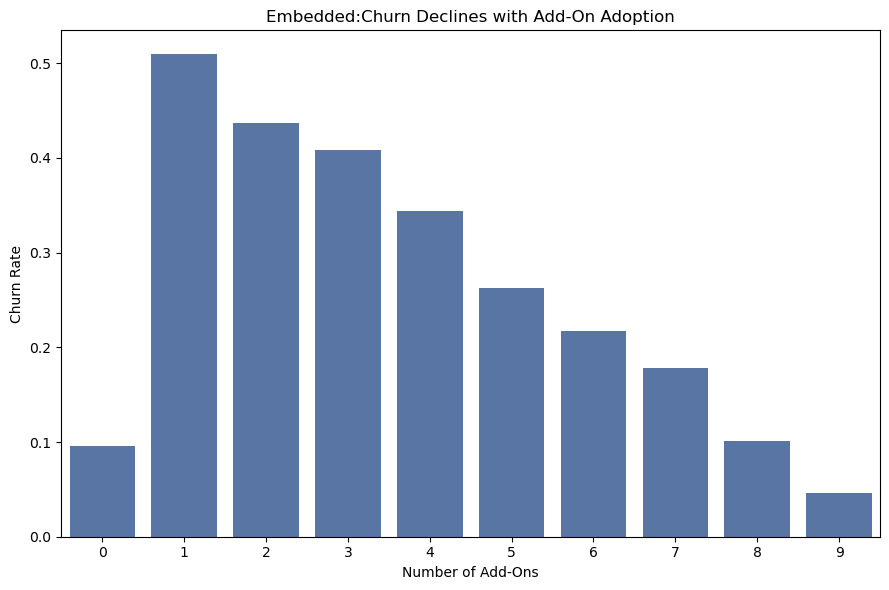

In [162]:
addon_churn = (
    df.groupby("services_addon_count")["left_flag_num"]
      .mean()
      .reset_index()
)

plt.figure(figsize=(9,6))
sns.barplot(
    data=addon_churn,
    x="services_addon_count",
    y="left_flag_num",
    color="#4C72B0"
)

plt.title("Embedded:Churn Declines with Add‑On Adoption")
plt.xlabel("Number of Add‑Ons")
plt.ylabel("Churn Rate")
plt.tight_layout()
plt.savefig(
    "Embedded_Churn Declines with Add‑On Adoption.jpg",
    dpi=300,
    bbox_inches="tight"
)

plt.show()



In [156]:

segment_df = pd.DataFrame({
    "segment": [
        "New & Under‑Adopted",
        "Bill‑Shock / Plan Mismatch",
        "Embedded Premium",
        "Service‑Recovered / Friction",
        "Stable Core"
    ],
    "share_of_base": [0.131, 0.103, 0.295, 0.064, 0.406],
    "churn_rate": [0.36, 0.325, 0.197, 0.182, 0.282],
    "avg_billed_per_month": [44.6, 76.0, 90.3, 65.5, 54.6]
})


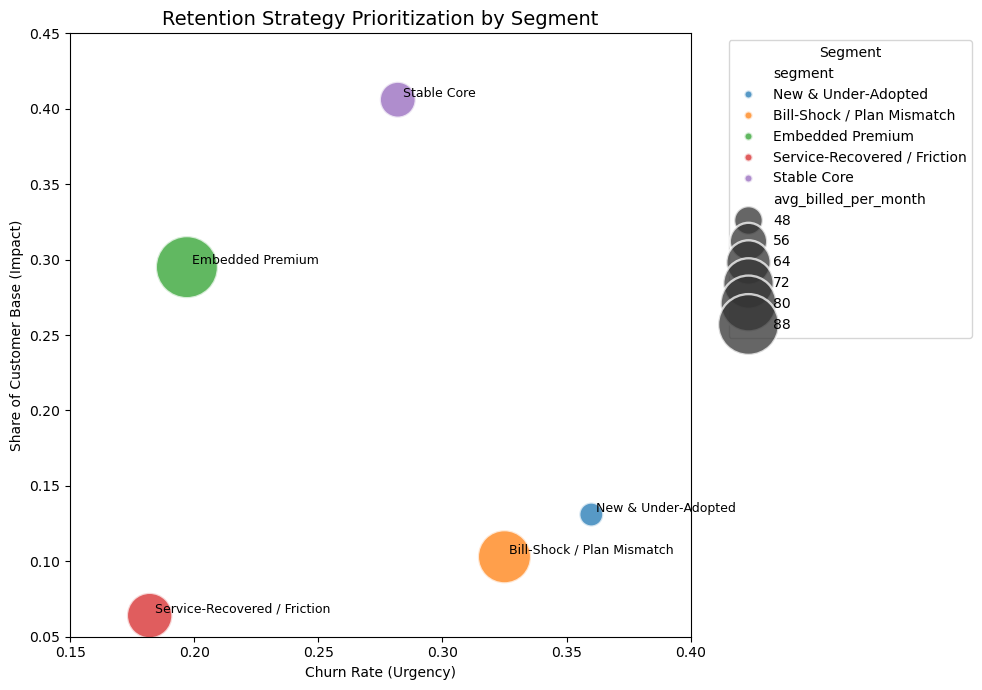

In [157]:

import seaborn as sns

plt.figure(figsize=(10, 7))

scatter = sns.scatterplot(
    data=segment_df,
    x="churn_rate",
    y="share_of_base",
    size="avg_billed_per_month",
    hue="segment",
    sizes=(300, 2000),
    alpha=0.75,
    legend="brief"
)

# Annotate segment names
for _, row in segment_df.iterrows():
    plt.text(
        row["churn_rate"] + 0.002,
        row["share_of_base"] + 0.002,
        row["segment"],
        fontsize=9
    )

plt.title("Retention Strategy Prioritization by Segment", fontsize=14)
plt.xlabel("Churn Rate (Urgency)")
plt.ylabel("Share of Customer Base (Impact)")

plt.xlim(0.15, 0.40)
plt.ylim(0.05, 0.45)

plt.legend(
    title="Segment",
    bbox_to_anchor=(1.05, 1),
    loc="upper left"
)

plt.tight_layout()
plt.savefig(
    "Retention Strategy Prioritization by Segment.jpg",
    dpi=300,
    bbox_inches="tight"
)

plt.show()

In [152]:


seg_df = pd.DataFrame({
    "segment": [
        "Bill‑Shock / Plan Mismatch",
        "Service‑Recovered / Friction",
        "Stable Core"
    ],
    "churn_rate": [0.3253, 0.1823, 0.2644],
    "fiber_optic_share": [0.5508, 0.4448, 0.4257],
    "month_to_month_share": [0.6041, 0.4807, 0.5481],
    "no_tech_support_share": [0.6076, 0.4282, 0.4822],
    "no_security_share": [0.6472, 0.4751, 0.4777],
    "avg_billed_per_month": [75.96, 65.49, 65.67],
    "share_of_base": [0.1031, 0.0642, 0.8327]
})


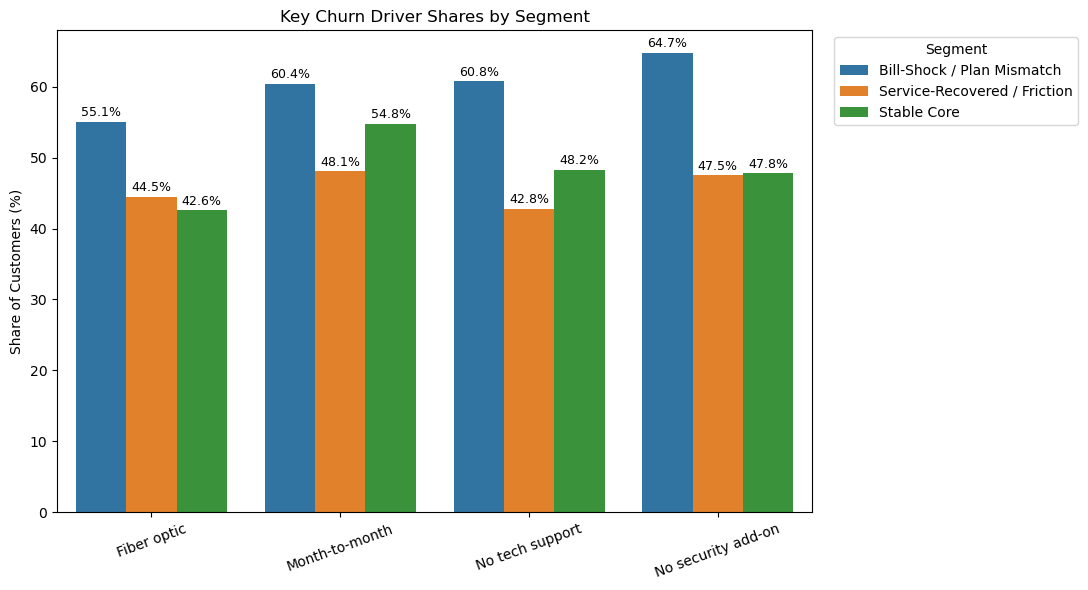

In [158]:
import seaborn as sns


# ✅ Only include columns that exist in seg_df
driver_cols = [
    "fiber_optic_share",
    "month_to_month_share",
    "no_tech_support_share",
    "no_security_share"
]

plot_df = seg_df.melt(
    id_vars="segment",
    value_vars=driver_cols,
    var_name="driver",
    value_name="share"
)

# Convert to %
plot_df["pct"] = plot_df["share"] * 100

# Make labels human‑readable
pretty_names = {
    "fiber_optic_share": "Fiber optic",
    "month_to_month_share": "Month‑to‑month",
    "no_tech_support_share": "No tech support",
    "no_security_share": "No security add‑on"
}
plot_df["driver"] = plot_df["driver"].map(pretty_names)

# Plot
plt.figure(figsize=(11,6))
ax = sns.barplot(
    data=plot_df,
    x="driver",
    y="pct",
    hue="segment"
)

plt.title("Key Churn Driver Shares by Segment")
plt.xlabel("")
plt.ylabel("Share of Customers (%)")
plt.xticks(rotation=20)

# Add % labels
for container in ax.containers:
    ax.bar_label(container, fmt="%.1f%%", padding=2, fontsize=9)

plt.legend(title="Segment", bbox_to_anchor=(1.02, 1), loc="upper left")
plt.tight_layout()

plt.savefig(
    "Key Churn Driver by Segment.jpg",
    dpi=300,
    bbox_inches="tight"
)

plt.show()

In [115]:
pct_table = (plot_df
             .pivot_table(index="segment", columns="driver", values="pct")
             .round(1))

pct_table


driver,Fiber optic,Month‑to‑month,No security add‑on,No tech support
segment,,,,
Bill‑Shock / Plan Mismatch,55.1,60.4,64.7,60.8
Service‑Recovered / Friction,44.5,48.1,47.5,42.8
Stable Core,42.6,54.8,47.8,48.2


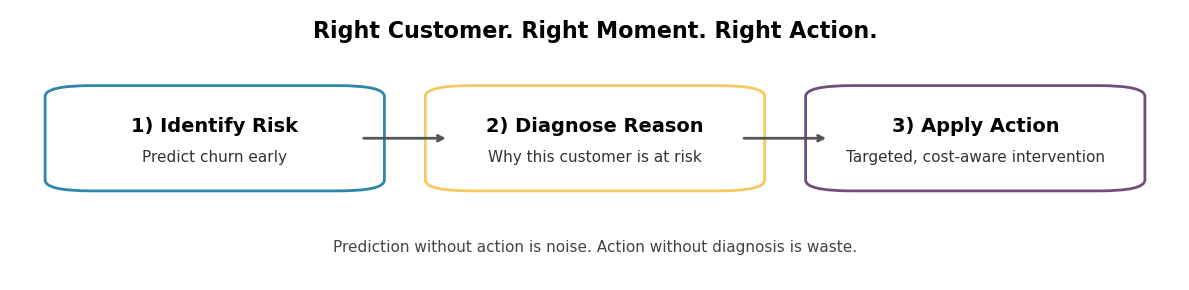

In [161]:

from matplotlib.patches import FancyBboxPatch

def step_flow():
    fig, ax = plt.subplots(figsize=(12, 3))
    ax.axis("off")

    # Boxes: (x, y, width, height)
    boxes = [
        (0.05, 0.35, 0.25, 0.35),
        (0.375, 0.35, 0.25, 0.35),
        (0.70, 0.35, 0.25, 0.35),
    ]

    titles = ["1) Identify Risk", "2) Diagnose Reason", "3) Apply Action"]
    subtitles = ["Predict churn early", "Why this customer is at risk", "Targeted, cost‑aware intervention"]
    colors = ["#2E86AB", "#F6C85F", "#6F4E7C"]

    # Draw boxes + text
    for (x, y, w, h), t, s, c in zip(boxes, titles, subtitles, colors):
        patch = FancyBboxPatch(
            (x, y), w, h,
            boxstyle="round,pad=0.02,rounding_size=0.04",
            linewidth=2, edgecolor=c, facecolor="white"
        )
        ax.add_patch(patch)
        ax.text(x + w/2, y + h*0.62, t, ha="center", va="center", fontsize=14, fontweight="bold")
        ax.text(x + w/2, y + h*0.30, s, ha="center", va="center", fontsize=11, color="#333333")

    # Arrows between boxes
    ax.annotate("", xy=(0.375, 0.525), xytext=(0.30, 0.525),
                arrowprops=dict(arrowstyle="->", lw=2, color="#555555"))
    ax.annotate("", xy=(0.70, 0.525), xytext=(0.625, 0.525),
                arrowprops=dict(arrowstyle="->", lw=2, color="#555555"))

    # Title + optional tagline
    ax.text(0.5, 0.92, "Right Customer. Right Moment. Right Action.",
            ha="center", va="center", fontsize=16, fontweight="bold")
    ax.text(0.5, 0.12, "Prediction without action is noise. Action without diagnosis is waste.",
            ha="center", va="center", fontsize=11, color="#444444")

    plt.tight_layout()
    plt.savefig(
    "right_customer_right_moment.jpg",
    dpi=300,
    bbox_inches="tight"
)

plt.show()

step_flow()


C:\Users\omogun01\AppData\Local\Temp\ipykernel_42280\3234203870.py:12: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(


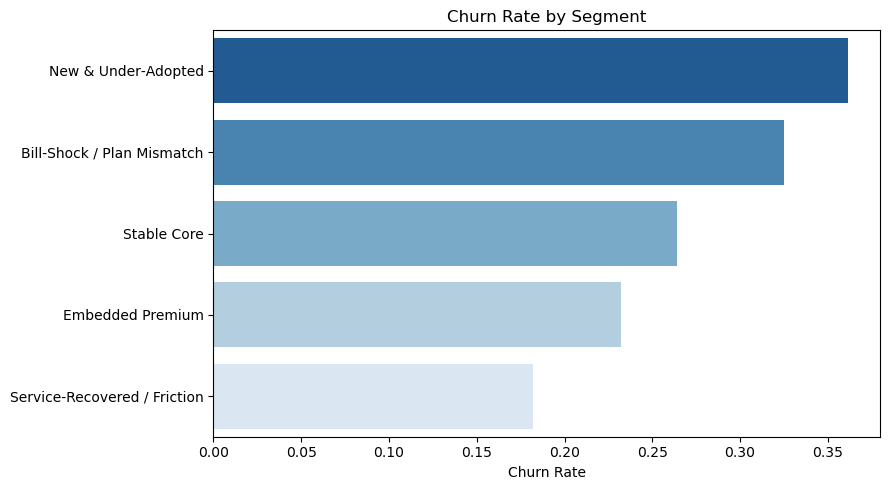

In [165]:



seg_churn = (
    df.groupby("segment_mece")["left_flag_num"]
    .mean()
    .reset_index()
    .sort_values("left_flag_num", ascending=False)
)

plt.figure(figsize=(9,5))
sns.barplot(
    data=seg_churn,
    x="left_flag_num",
    y="segment_mece",
    palette="Blues_r"
)

plt.title("Churn Rate by Segment")
plt.xlabel("Churn Rate")
plt.ylabel("")

plt.tight_layout()
plt.savefig(
    "by_Segment.jpg",
    dpi=300,
    bbox_inches="tight"
)

plt.show()


In [180]:


holdout = pd.read_csv("retentiondata_case_holdout.csv") 


In [182]:
holdout.columns


Index(['acct_ref', 'cust_ref', 'has_dependents', 'tenure_mo', 'home_phone',
       'multi_line', 'internet_plan', 'add_on_security', 'add_on_backup',
       'add_on_protection', 'tech_support_std', 'stream_tv', 'stream_movies',
       'contract_term', 'e_bill_opt_in', 'pay_method', 'monthly_fee',
       'total_billed', 'left_flag', 'fiscal_qtr', 'gender', 'age_years',
       'is_married', 'dependents_count', 'referred_friend', 'referrals_count',
       'recent_offer', 'avg_long_dist_fee', 'internet_tech', 'avg_gb_download',
       'premium_support', 'stream_music', 'unlimited_data_opt',
       'refunds_total', 'extra_data_fees_total', 'long_dist_fees_total'],
      dtype='object')

In [183]:
[c for c in holdout.columns if "churn" in c.lower() or "left" in c.lower() or "target" in c.lower()]


['left_flag']

In [187]:
holdout["left_flag"].unique()


array(['Yes', 'No'], dtype=object)

In [188]:
y_holdout = holdout["left_flag"].map({"Yes": 1, "No": 0})
X_holdout_raw = holdout.drop(columns=["left_flag"])


In [190]:
print([name for name in globals() if "model" in name.lower()])


['model_ready', 'model_results', 'best_model', 'xgb_model']


In [239]:


def add_engineered_features(df: pd.DataFrame) -> pd.DataFrame:
    df = df.copy()

    # --- binaries from Yes/No style columns ---
    yn_cols = [
        "stream_movies", "stream_tv", "stream_music",
        "tech_support_std", "premium_support",
        "add_on_security", "add_on_protection", "add_on_backup",
        "unlimited_data_opt", "referred_friend"
    ]
    for c in yn_cols:
        if c in df.columns:
            df[c + "_01"] = df[c].map({"Yes": 1, "No": 0}).fillna(0).astype(int)

    # referral flag (same idea, but your model expects referral_flag)
    if "referred_friend" in df.columns:
        df["referral_flag"] = df["referred_friend"].map({"Yes": 1, "No": 0}).fillna(0).astype(int)

    # refunds flag
    if "refunds_total" in df.columns:
        df["refund_flag"] = (df["refunds_total"].fillna(0) > 0).astype(int)

    # services_addon_count
    addon_01_cols = [c for c in ["add_on_security_01","add_on_backup_01","add_on_protection_01",
                                "tech_support_std_01","premium_support_01"] if c in df.columns]
    if addon_01_cols:
        df["services_addon_count"] = df[addon_01_cols].sum(axis=1)

    # avg billed per month
    if "total_billed" in df.columns and "tenure_mo" in df.columns:
        denom = df["tenure_mo"].replace(0, np.nan)
        df["avg_billed_per_month"] = (df["total_billed"] / denom).fillna(0)

    # early lifecycle flag
    if "tenure_mo" in df.columns:
        df["early_lifecycle_flag"] = (df["tenure_mo"] <= 12).astype(int)

        # tenure_group (simple bins; adjust if your project used different cutoffs)
        df["tenure_group"] = pd.cut(
            df["tenure_mo"],
            bins=[-1, 6, 12, 24, 60, 10**9],
            labels=["0-6","7-12","13-24","25-60","60+"]
        ).astype(str)

    # high usage flag (pick a simple percentile threshold)
    if "avg_gb_download" in df.columns:
        p80 = df["avg_gb_download"].quantile(0.80)
        df["high_usage_flag"] = (df["avg_gb_download"] >= p80).astype(int)

    # data fee friction flag
    if "extra_data_fees_total" in df.columns:
        df["data_fee_friction_flag"] = (df["extra_data_fees_total"].fillna(0) > 0).astype(int)

    # age_group (simple bins; adjust if needed)
    if "age_years" in df.columns:
        df["age_group"] = pd.cut(
            df["age_years"],
            bins=[0, 25, 35, 45, 55, 65, 200],
            labels=["<25","25-34","35-44","45-54","55-64","65+"]
        ).astype(str)

    return df


In [240]:
# target
y_holdout = holdout["left_flag"].map({"Yes": 1, "No": 0})
X_holdout_raw = holdout.drop(columns=["left_flag"])

# add engineered columns
X_holdout_fe = add_engineered_features(X_holdout_raw)

# predict (try best_model first)
y_proba = best_model.predict_proba(X_holdout_fe)[:, 1]


In [241]:
from sklearn.metrics import roc_auc_score, confusion_matrix, classification_report

threshold = 0.40
y_pred = (y_proba >= threshold).astype(int)

print("Holdout ROC-AUC:", roc_auc_score(y_holdout, y_proba))
tn, fp, fn, tp = confusion_matrix(y_holdout, y_pred).ravel()
print("TN FP FN TP:", tn, fp, fn, tp)
print(classification_report(y_holdout, y_pred, digits=3))


Holdout ROC-AUC: 0.8995571481168424
TN FP FN TP: 903 131 99 274
              precision    recall  f1-score   support

           0      0.901     0.873     0.887      1034
           1      0.677     0.735     0.704       373

    accuracy                          0.837      1407
   macro avg      0.789     0.804     0.796      1407
weighted avg      0.842     0.837     0.839      1407



In [242]:
type(model_ready)


pandas.core.frame.DataFrame

In [196]:
from sklearn.metrics import roc_auc_score, accuracy_score, precision_score, recall_score, f1_score, confusion_matrix

# Metrics
roc = roc_auc_score(y_holdout, y_proba)
acc = accuracy_score(y_holdout, y_pred)
prec = precision_score(y_holdout, y_pred)
rec = recall_score(y_holdout, y_pred)
f1 = f1_score(y_holdout, y_pred)

results_summary = pd.DataFrame({
    "Metric": ["ROC-AUC", "Accuracy", "Precision", "Recall", "F1-Score"],
    "Value": [roc, acc, prec, rec, f1]
})

results_summary


,Metric,Value
0,ROC-AUC,0.899557
1,Accuracy,0.836532
2,Precision,0.676543
3,Recall,0.734584
4,F1-Score,0.704370


In [243]:
holdout_out = holdout.copy()
holdout_out["p_churn"] = y_proba
holdout_out.to_csv("scored_holdout.csv", index=False)


In [244]:
submission = pd.DataFrame({
    "acct_ref": holdout["acct_ref"],
    "cust_ref": holdout["cust_ref"],
    "churn_probability": y_proba
})

submission.to_csv("scored_holdout.csv", index=False)
